In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import math

from scipy.spatial.transform import Rotation

In [2]:
Q = np.array([[],[],[]])

In [3]:
for i in range(2):
    for j in range(2):
        for k in range(2):
            Qijk = np.array([[i],[j],[k]])
            Q = np.hstack((Q,Qijk))

In [4]:
Q

array([[0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 0., 0., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1.]])

In [5]:
K = np.array([[1000,0,960],[0,1000,540],[0,0,1]])
temp = math.sqrt(1/2)
R = np.array([[temp,-temp,0],[temp,temp,0],[0,0,1]])
t = np.array([[0],[0],[10]])

# Exercise 4.1

In [6]:
P = K@np.hstack((R,t))

In [7]:
np.around(P)

array([[ 7.07e+02, -7.07e+02,  9.60e+02,  9.60e+03],
       [ 7.07e+02,  7.07e+02,  5.40e+02,  5.40e+03],
       [ 0.00e+00,  0.00e+00,  1.00e+00,  1.00e+01]])

In [8]:
def projectpoints(K, R, t, Q):
    Rt = np.hstack((R,t))
    Qh = np.vstack((Q,np.ones(len(Q[0]))))
    q = K@Rt@Qh
    return q[:-1]/q[-1]

In [9]:
q = projectpoints(K, R, t, Q)

In [10]:
np.around(q,2)

array([[ 960.  ,  960.  ,  889.29,  895.72, 1030.71, 1024.28,  960.  ,
         960.  ],
       [ 540.  ,  540.  ,  610.71,  604.28,  610.71,  604.28,  681.42,
         668.56]])

# Exercise 4.2

In [11]:
def CrossOp(p):
    px = np.array([  [0,-p[2],p[1]],[p[2],0,-p[0]],[-p[1],p[0],0]   ])
    return px

In [12]:
def EstimateP(q,Q):
    qh = np.vstack((q,np.ones(len(q[0]))))
    Qh = np.vstack((Q,np.ones(len(Q[0]))))
    B = np.kron(Qh[:,0],CrossOp(qh[:,0]))
    for i in range(1,len(qh[0])):
        Btemp = np.kron(Qh[:,i],CrossOp(qh[:,i]))
        B = np.vstack((B,Btemp))

    _,_,vh = np.linalg.svd(B.T@B)
    P = vh[-1, :]
    P = P.reshape(4,3).T
    P = (P/P[-1, -1] * 10)   #make two matrix into same scale t = [0,0,10]
    return P

In [13]:
#with normalize
def normalize2D(p):
    ph = np.vstack((p, np.ones(len(p[0]))))
    m = np.mean(p,1)
    stdd = np.std(p,1)
    T = np.diag([1/stdd[0],1/stdd[1],1])
    T[0][2]=-m[0]/stdd[0]
    T[1][2]=-m[1]/stdd[1]
    q = T@ph
    return q,T

In [14]:
def EstimatePnorm(q,Q):
    qh,qT = normalize2D(q)
 #   Qh,QT = normalize2D(Q)
    B = np.kron(Qh[:,0],CrossOp(qh[:,0]))
    for i in range(1,len(qh[0])):
        Btemp = np.kron(Qh[:,i],CrossOp(qh[:,i]))
        B = np.vstack((B,Btemp))

    _,_,vh = np.linalg.svd(B.T@B)
    Pn = vh[-1, :]
    Pn = Pn.reshape(4,3).T
    P = np.linalg.inv(qT)@Pn
    P = (P/P[-1, -1] * 10)   #make two matrix into same scale t = [0,0,10]
    return P

In [15]:
qh = np.vstack((q,np.ones(len(q[0]))))
Qh = np.vstack((Q,np.ones(len(Q[0]))))

In [16]:
#without normalize 
Pe = EstimateP(q,Q)
qe = Pe@Qh
qe = qe[:-1]/qe[-1]
error1 = np.linalg.norm(q-qe)/np.linalg.norm(q)
#with normalize
Pn = EstimatePnorm(q,Q)
qne = Pn@Qh
qne = qne[:-1]/qne[-1]
error2 = np.linalg.norm(q-qne)/np.linalg.norm(q)
print("the reprojetion error without normalize is : %s" %error1,"\n")
print("the reprojetion error with normalize is : %s" %error2,"\n")

#Normalization improve the estimation performance significantly!!!!

the reprojetion error without normalize is : 2.3344818826631198e-12 

the reprojetion error with normalize is : 2.6192282102617606e-16 



# Exercise 4.3

In [17]:
def checkerboard_points(n,m):
    Q = np.array([[],[],[]])
    for i in range(n):
        for j in range(m):
            Qij = np.array([[i-((n-1)/2)],[j-((m-1)/2)],[0]])
            Q = np.hstack((Q,Qij))
    return Q

# Exercise 4.4

In [18]:
Ra = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix()
Rb = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()
Rc = Rotation.from_euler('xyz', [-np.pi/10, 0, 0]).as_matrix()

Q = checkerboard_points(10,20)
Qa = Ra@Q
Qb = Rb@Q
Qc = Rc@Q

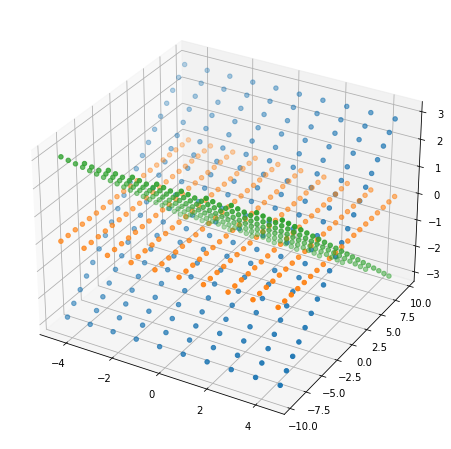

In [19]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')  # syntax for 3-D projection
ax.scatter3D(Qa[0,:], Qa[1,:], Qa[2,:])
ax.scatter3D(Qb[0,:], Qb[1,:], Qb[2,:])
ax.scatter3D(Qc[0,:], Qc[1,:], Qc[2,:])
plt.show()

In [20]:
K = np.array([[1000,0,960],[0,1000,540],[0,0,1]])
temp = math.sqrt(1/2)
R = np.array([[temp,-temp,0],[temp,temp,0],[0,0,1]])
t = np.array([[0],[0],[10]])
P = K@np.hstack((R,t))
def projectpoints(K, R, t, Q):
    Rt = np.hstack((R,t))
    Qh = np.vstack((Q,np.ones(len(Q[0]))))
    q = K@Rt@Qh
    return q[:-1]/q[-1]


In [21]:
qa = projectpoints(K, R, t, Qa)
qb = projectpoints(K, R, t, Qb)
qc = projectpoints(K, R, t, Qc)

# Exercise 4.5

In [22]:
Q = checkerboard_points(10,20)
Qa = Ra@Q
Qb = Rb@Q
Qc = Rc@Q
qa = projectpoints(K, R, t, Qa)
qb = projectpoints(K, R, t, Qb)
qc = projectpoints(K, R, t, Qc)

In [23]:
def normalize2D(pi):
    #pih = np.vstack((pi, np.ones(len(pi[0]))))
    m = np.mean(pi,1)
    stdd = np.std(pi,1)
    T = np.diag([1/stdd[0],1/stdd[1],1])
    T[0][2]=-m[0]/stdd[0]
    T[1][2]=-m[1]/stdd[1]
    qi = T@pi
    return qi,T

def CrossOp(p):
    px = np.array([  [0,-p[2],p[1]],[p[2],0,-p[0]],[-p[1],p[0],0]   ])
    return px

In [24]:
def hest(q1,q2):    
    ###q1 = H@q2
    ##qs = H@Qomega
    q1 = np.vstack((q1, np.ones(len(q1[0]))))
    q2 = np.vstack((q2, np.ones(len(q2[0]))))
    q1,T1 = normalize2D(q1)
    q2,T2 = normalize2D(q2)
    B = np.kron(q2[:,0],CrossOp(q1[:,0]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i],CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    _, _, vh = np.linalg.svd(B.T@B)
    H = np.reshape(vh[-1],(3,3)) 
    H = np.linalg.inv(T1)@H.T@T2
#    H = H.round(2)
    
    return H

In [25]:
def estimateHomographies(Q_omega,qs):
    Hs = []
    for q in qs:
        H = hest(q,Q_omega)
        Hs.append(H)
    
    return Hs

In [26]:
Qomega = Q[0:2]
Qomegah = np.vstack((Qomega,np.ones(len(Qomega[0]))))
qs = [qa,qb,qc]

In [27]:
Hs = estimateHomographies(Qomega,qs)

In [28]:
##test function
for i,q in enumerate(qs):
    qest = Hs[i]@Qomegah
    qest = qest[:-1]/qest[-1]
#    error = np.sum((q-qest)/np.linalg.norm(q))
    error = np.linalg.norm(q-qest)/np.linalg.norm(q)
    print("the error %d is" %i,error)

the error 0 is 3.628905968414357e-16
the error 1 is 3.8621057311420056e-16
the error 2 is 4.0757097210150884e-16


# Exercise 4.6

In [29]:
def Vtemp(H):
    v12 = np.array([H[0,0]*H[0,1],H[0,0]*H[1,1]+H[1,0]*H[0,1],H[1,0]*H[1,1],
                   H[2,0]*H[0,1]+H[0,0]*H[2,1],H[2,0]*H[1,1]+H[1,0]*H[2,1],H[2,0]*H[2,1]])
    v11 = np.array([H[0,0]*H[0,0],H[0,0]*H[1,0]+H[1,0]*H[0,0],H[1,0]*H[1,0],
                   H[2,0]*H[0,0]+H[0,0]*H[2,0],H[2,0]*H[1,0]+H[1,0]*H[2,0],H[2,0]*H[2,0]])
    v22 = np.array([H[0,1]*H[0,1],H[0,1]*H[1,1]+H[1,1]*H[0,1],H[1,1]*H[1,1],
                   H[2,1]*H[0,1]+H[0,1]*H[2,1],H[2,1]*H[1,1]+H[1,1]*H[2,1],H[2,1]*H[2,1]])
    Vtemp = np.vstack([v12,v11-v22])
    
    return Vtemp

In [30]:
def formV(Hs):
    V = Vtemp(Hs[0])
    for k in range(1,len(Hs)):
        vtemp = Vtemp(Hs[k])
        V=np.vstack((V,vtemp))
    return V

In [31]:
def estimate_b(Hs):
    V = formV(Hs)
    _,_,Vt = np.linalg.svd(V)
    b = Vt[-1]
    
    return b

In [32]:
b = estimate_b(Hs)
Besti = np.array([ [b[0],b[1],b[3]],[b[1],b[2],b[4]],[b[3],b[4],b[5]]])
Btrue = np.linalg.inv(K).T@np.linalg.inv(K)
Besti = (Besti/Besti[-1,-1])*Btrue[-1,-1]

In [33]:
error = np.linalg.norm(Btrue-Besti)/np.linalg.norm(Btrue)
print("the error %d is" %i,error)

the error 2 is 2.4493996807249597e-18


# Exercise 4.7

In [34]:
def estimateIntrisics(Hs):
    b = estimate_b(Hs)
    B11, B12, B22, B13, B23, B33 = b[0], b[1], b[2], b[3], b[4], b[5]
    v0 = (B12*B13-B11*B23)/(B11*B22-B12*B12)
    lamda = B33-(B13*B13+v0*(B12*B13-B11*B23))/B11
    alpha = math.sqrt(lamda/B11)
    beta = math.sqrt(lamda*B11/(B11*B22-B12*B12))
    gama = -B12*alpha*alpha*beta/lamda
    u0 = (gama*v0/beta) - (B13*alpha*alpha/lamda)
    Kest = np.array([[alpha,gama,u0],[0,beta,v0],[0,0,1]]).round(2)
    return Kest

In [35]:
Kest = estimateIntrisics(Hs)
Kest

array([[1000.,   -0.,  960.],
       [   0., 1000.,  540.],
       [   0.,    0.,    1.]])

In [36]:
K

array([[1000,    0,  960],
       [   0, 1000,  540],
       [   0,    0,    1]])

# Exercise 4.8

In [37]:
def estimateExtrinsics(K, Hs):
    Rs = []
    ts = []
    for i in range(len(Hs)):
        H = Hs[i]
        lamda = 1/np.linalg.norm((np.linalg.inv(K)@H[:,0]),2)
        r1 = lamda*np.linalg.inv(K)@H[:,0]
        r2 = lamda*np.linalg.inv(K)@H[:,1]
        r3 = np.cross(r1,r2)
        t = lamda*np.linalg.inv(K)@H[:,2]
        Rt = np.vstack((r1,r2,r3)).T
        
        Rs.append(Rt)
        ts.append(t)
    
    return Rs, ts

In [38]:
Rs,ts = estimateExtrinsics(K,Hs)

In [39]:
np.around(Rs,2)

array([[[-0.71,  0.67,  0.22],
        [-0.71, -0.67, -0.22],
        [-0.  , -0.31,  0.95]],

       [[ 0.71, -0.71,  0.  ],
        [ 0.71,  0.71,  0.  ],
        [-0.  , -0.  ,  1.  ]],

       [[ 0.71, -0.67, -0.22],
        [ 0.71,  0.67,  0.22],
        [ 0.  , -0.31,  0.95]]])

In [40]:
np.around(R,2)

array([[ 0.71, -0.71,  0.  ],
       [ 0.71,  0.71,  0.  ],
       [ 0.  ,  0.  ,  1.  ]])

# Calibrate camera

In [41]:
def normalize2D(pi):
    #pih = np.vstack((pi, np.ones(len(pi[0]))))
    m = np.mean(pi,1)
    stdd = np.std(pi,1)
    T = np.diag([1/stdd[0],1/stdd[1],1])
    T[0][2]=-m[0]/stdd[0]
    T[1][2]=-m[1]/stdd[1]
    qi = T@pi
    return qi,T

def CrossOp(p):
    px = np.array([  [0,-p[2],p[1]],[p[2],0,-p[0]],[-p[1],p[0],0]   ])
    return px

def hest(q1,q2):    
    #q1 equals the mapping point q, q2 equals the origin point Q
    #q1,q2 should be inhomogenious coordinates
    q1 = np.vstack((q1, np.ones(len(q1[0]))))
    q2 = np.vstack((q2, np.ones(len(q2[0]))))
    q1,T1 = normalize2D(q1)
    q2,T2 = normalize2D(q2)
    B = np.kron(q2[:,0],CrossOp(q1[:,0]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i],CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    u, s, vh = np.linalg.svd(B.T@B)
    H = np.reshape(vh[-1],(3,3)) 
    H = np.linalg.inv(T1)@H.T@T2
#    H = H.round(2)    
    return H

def estimateHomographies(Q_omega,qs):
    Hs = []
    for q in qs:
        H = hest(q,Q_omega)
        Hs.append(H)    
    return Hs

def Vtemp(H):
    v12 = np.array([H[0,0]*H[0,1],H[0,0]*H[1,1]+H[1,0]*H[0,1],H[1,0]*H[1,1],
                   H[2,0]*H[0,1]+H[0,0]*H[2,1],H[2,0]*H[1,1]+H[1,0]*H[2,1],H[2,0]*H[2,1]])
    v11 = np.array([H[0,0]*H[0,0],H[0,0]*H[1,0]+H[1,0]*H[0,0],H[1,0]*H[1,0],
                   H[2,0]*H[0,0]+H[0,0]*H[2,0],H[2,0]*H[1,0]+H[1,0]*H[2,0],H[2,0]*H[2,0]])
    v22 = np.array([H[0,1]*H[0,1],H[0,1]*H[1,1]+H[1,1]*H[0,1],H[1,1]*H[1,1],
                   H[2,1]*H[0,1]+H[0,1]*H[2,1],H[2,1]*H[1,1]+H[1,1]*H[2,1],H[2,1]*H[2,1]])
    Vtemp = np.vstack([v12,v11-v22])    
    return Vtemp

def formV(Hs):
    V = Vtemp(Hs[0])
    for k in range(1,len(Hs)):
        vtemp = Vtemp(Hs[k])
        V=np.vstack((V,vtemp))
    return V

def estimate_b(Hs):
    V = formV(Hs)
    _,_,Vt = np.linalg.svd(V)
    b = Vt[-1]    
    return b

def estimateIntrisics(Hs):
    b = estimate_b(Hs)
    B11, B12, B22, B13, B23, B33 = b[0], b[1], b[2], b[3], b[4], b[5]
    v0 = (B12*B13-B11*B23)/(B11*B22-B12*B12)
    lamda = B33-(B13*B13+v0*(B12*B13-B11*B23))/B11
    alpha = math.sqrt(lamda/B11)
    beta = math.sqrt(lamda*B11/(B11*B22-B12*B12))
    gama = -B12*alpha*alpha*beta/lamda
    u0 = (gama*v0/beta) - (B13*alpha*alpha/lamda)
    Kest = np.array([[alpha,gama,u0],[0,beta,v0],[0,0,1]]).round(2)
    return Kest

def estimateExtrinsics(K, Hs):
    Rs = []
    ts = []
    for i in range(len(Hs)):
        H = Hs[i]
        lamda = 1/np.linalg.norm((np.linalg.inv(K)@H[:,0]),2)
        r1 = lamda*np.linalg.inv(K)@H[:,0]
        r2 = lamda*np.linalg.inv(K)@H[:,1]
        r3 = np.cross(r1,r2)
        t = lamda*np.linalg.inv(K)@H[:,2]
        Rt = np.vstack((r1,r2,r3)).T
        
        Rs.append(Rt)
        ts.append(t)    
    return Rs, ts

In [42]:
def calibratecamera(qs,Q):
    Qomega = Q[0:2]
    Hs = estimateHomographies(Qomega,qs)
    Ks = estimateIntrisics(Hs)
    Rs, ts =estimateExtrinsics(Ks,Hs)    
    return Ks, Rs,ts

In [43]:
K = np.array([[1000,0,960],[0,1000,540],[0,0,1]])
temp = math.sqrt(1/2)
R = np.array([[temp,-temp,0],[temp,temp,0],[0,0,1]])
t = np.array([[0],[0],[10]])

def checkerboard_points(n,m):
    Q = np.array([[],[],[]])
    for i in range(n):
        for j in range(m):
            Qij = np.array([[i-((n-1)/2)],[j-((m-1)/2)],[0]])
            Q = np.hstack((Q,Qij))
    return Q

def projectpoints(K, R, t, Q):
    Rt = np.hstack((R,t))
    Qh = np.vstack((Q,np.ones(len(Q[0]))))
    q = K@Rt@Qh
    return q[:-1]/q[-1]

Ra = Rotation.from_euler('xyz', [np.pi/10, 0, 0]).as_matrix()
Rb = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()
Rc = Rotation.from_euler('xyz', [-np.pi/10, 0, 0]).as_matrix()

Q = checkerboard_points(10,20)
Qa = Ra@Q
Qb = Rb@Q
Qc = Rc@Q

qa = projectpoints(K, R, t, Qa)
qb = projectpoints(K, R, t, Qb)
qc = projectpoints(K, R, t, Qc)

qs = [qa,qb,qc]

In [44]:
Ks, Rs,ts = calibratecamera(qs,Q)

In [45]:
Ks

array([[1000.,   -0.,  960.],
       [   0., 1000.,  540.],
       [   0.,    0.,    1.]])

In [46]:
K

array([[1000,    0,  960],
       [   0, 1000,  540],
       [   0,    0,    1]])